# Example 1: Use default processing graph to pre-process single Sentinel-1 Level-1 SLC image

## 1. Requirements

- Installation of SenSARP
- Installation of ESA's SNAP Toolbox version >8.0.3
    - Currently only SNAP version 8.0 can be downloaded from the ESA website (https://step.esa.int/main/download/snap-download/). To update SNAP to a version >8.0.3 please start the SNAP software. You will be asked if you want to search for update. After the updates are installed you need to restart SNAP to initialize the installed updates.
    - SNAP Toolbox need libgfortran for specific operations but currently libgfortran is not installed during the installation process of SNAP therefore you might use ```sudo apt-get install gfortran```

- Sentinel-1 SLC data
    - Instruction how to download Sentinel 1 data are given in Section 2

## 2. Download sample data from Sentinel Data Hub
### Option 1: Download data from Sentinel Data Hub manually or via python package sentinelsat

 <span style="color:red">Create Account (https://scihub.copernicus.eu/dhus/#/self-registration)</span>. (**<span style="color:red">Attention: Problem by using Copernicus Open Access Hub might be that older data is offline and need to be triggered first</span>)**. More information can be found at https://scihub.copernicus.eu/userguide/DataRestoration. Instruction to manually download data from Copernicus Open Access Hub can be found at https://blogs.fu-berlin.de/reseda/esa-scihub/. You can also try to download the data via python package sentinelsat

### How to use sentinelsat

In [1]:
# connect to the API
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
user = 'user'
password = 'password'
# initialize settings
api = SentinelAPI(user, password)

Search for available data

In [2]:
# search by polygon (MNI test site coordinates), time, and SciHub query keywords
footprint = geojson_to_wkt(read_geojson('coordinates_mni.geojson'))
products = api.query(footprint,
                     date=('20210701', '20210702'),
                     platformname='Sentinel-1',
                     producttype='SLC')
print('Following products will be downloaded')
print(api.to_dataframe(products).title.values)

print('These {} product need {} Gb of disk space'.format(len(products), api.get_products_size(products)))

Following products will be downloaded
['S1B_IW_SLC__1SDV_20210701T051738_20210701T051805_027596_034B44_2DCF']
These 1 product need 7.72 Gb of disk space


Start download process (**<span style="color:red">Attention: might take a while and data will requries some free disk space</span>)**

In [3]:
# download all results from the search
# files will be downloaded to specified path
import os
path = os.path.expanduser('~/Desktop/data')
try:
    os.makedirs(path)
except: FileExistsError
api.download_all(products, path)

MD5 checksumming:   0%|          | 0.00/4.62G [00:00<?, ?B/s]

ResultTuple(downloaded={'87bc6000-e45b-4e06-9c8e-1db1908db1ca': {'id': '87bc6000-e45b-4e06-9c8e-1db1908db1ca', 'title': 'S1B_IW_SLC__1SDV_20210701T051738_20210701T051805_027596_034B44_2DCF', 'size': 4620218028, 'md5': 'b142da92c874236fbdd6572480b96128', 'date': datetime.datetime(2021, 7, 1, 5, 17, 38, 754000), 'footprint': 'POLYGON((14.731479 47.650288,11.295774 48.053822,11.672503 49.676376,15.223297 49.271305,14.731479 47.650288))', 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('87bc6000-e45b-4e06-9c8e-1db1908db1ca')/$value", 'Online': True, 'Creation Date': datetime.datetime(2021, 7, 1, 7, 24, 3, 755000), 'Ingestion Date': datetime.datetime(2021, 7, 1, 7, 21, 46, 931000), 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('87bc6000-e45b-4e06-9c8e-1db1908db1ca')/Products('Quicklook')/$value", 'path': '/home/test/Desktop/data/S1B_IW_SLC__1SDV_20210701T051738_20210701T051805_027596_034B44_2DCF.zip', 'downloaded_bytes': 4620218028}}, retrieval_trigge

### Option 2: Manually search and download data from Alaska Satellite Facility (ASF)

You can search for Sentinel-1 data at https://search.asf.alaska.edu/. A NASA EOSDIS Earthdata Login account is required for downloading data and tools from ASF. Registering for an Earthdata Login account is free (https://urs.earthdata.nasa.gov/home). Instructions how to download data from ASF can be found at https://asf.alaska.edu/wp-content/uploads/2019/02/asf_datarecipe_bulk_download_from_vertex_python_script_v1.pdf.

## 3. Use default processing graph to pre-process a single Sentinel-1 Level-1 SLC image

Set paths for

- input_folder (path to stored Sentinel-1 SLC data (zip files) e.g. "~/Downloads")
- output_folder (path where processed data will be stored e.g. "~/output")
- gpt_loction (gpt is located in the bin folder of your SNAP installation)' 

In [4]:
input_folder = path
output_folder = path
gpt_location = os.path.expanduser('~/snap/bin/gpt')

Create config file with information about input folder, output folder and gpt path

In [5]:
import yaml

with open('sample_config_file.yaml') as stream:
   data = yaml.safe_load(stream)

data['input_folder'] = input_folder
data['output_folder'] = output_folder
data['gpt'] = gpt_location

with open('test_config_file.yaml', 'wb') as stream:
   yaml.safe_dump(data, stream, default_flow_style=False, 
                  explicit_start=True, allow_unicode=True, encoding='utf-8')

Optional config options for subsetting

In [6]:
with open('test_config_file.yaml') as stream:
   data = yaml.safe_load(stream)

## Define region of interest
data['region']['lr']['lat'] = 48.2 # lower right latitude
data['region']['lr']['lon'] = 11.9 # lower right longitude
data['region']['ul']['lat'] = 48.4 # upper left latitude
data['region']['ul']['lon'] = 11.6 # upper left longitude
data['region']['subset'] = 'yes'

with open('test_config_file.yaml', 'wb') as stream:
   yaml.safe_dump(data, stream, default_flow_style=False, 
                  explicit_start=True, allow_unicode=True, encoding='utf-8')

Start pre-processing steps

In [7]:
from sar_pre_processing.sar_pre_processor import *
import warnings
warnings.filterwarnings("ignore")

processing = SARPreProcessor(config='test_config_file.yaml')
processing.create_processing_file_list()
print('start step 1')
processing.pre_process_step1()
print('start step 2')
processing.pre_process_step2()
print('start step 3')
processing.pre_process_step3()
print('start add netcdf information')
processing.add_netcdf_information()
print('start create netcdf stack')
processing.create_netcdf_stack()

INFO:root:Found files within input folder: 1
INFO:root:year not specified
INFO:root:area of interest not specified
INFO:root:Number of found files that were double processed: 0.0
INFO:root:Number of found files with border issues: 0
INFO:root:area of interest specified
INFO:root:normalisation angle not specified, default value of 35 is used for processing
INFO:ComponentProgress:0
INFO:ComponentProgress:0
INFO:root:Process S1B_IW_SLC__1SDV_20210701T051738_20210701T051805_027596_034B44_2DCF.zip with SNAP.


start step 1


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/07


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-07-01T00:00:000Z TO 2021-07-31T24:00:000Z]
OpenSearch: 38 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-07-01T00:00:000Z TO 2021-07-31T24:00:000Z]
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-06-01T00:00:000Z TO 2021-06-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/07


...12%...24%..34%...46%

INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/SRTMGL1/N48E011.SRTMGL1.hgt.zip
INFO: org.esa.snap.engine_utilities.download.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/dem/egm96/ww15mgh_b.zip


...58%..68%...80%... done.


INFO:root:0
INFO:root:Single image, no co-register of images necessary
INFO:root:multi temporal filter cannot applied to a single image, just single speckle filter is applied
INFO:ComponentProgress:0
INFO:ComponentProgress:0


start step 2
start step 3


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...12%...24%.

27585 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
27602 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
27658 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


..36%...48%...60%...72%...84%.. done.


INFO:root:0
INFO:root:2021-08-29 17:54:26.666351


start add netcdf information


INFO:root:Number of scenes found for processing: 1


start create netcdf stack

Scene 1 of 1
/home/test/Desktop/data/step3/S1B_IW_SLC__1SDV_20210701T051738_20210701T051805_027596_034B44_2DCF_GC_RC_No_Su_speckle.nc


## 4. View processed data

Load netcdf file with processed data

In [8]:
import os
print(os.getcwd())
print(output_folder)

/home/test/Desktop/sar-pre-processing/docs/notebooks
/home/test/Desktop/data


In [9]:
from netCDF4 import Dataset
import numpy as np

my_example_nc_file = os.path.join(output_folder, 'data.nc')
data = Dataset(my_example_nc_file, mode='r') 

View information about dataset

In [10]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(1603), lon(2403), time(1)
    variables(dimensions): float32 time(time), float32 orbitdirection(time), float32 relorbit(time), float32 satellite(time), float32 lat(lat), float32 lon(lon), float32 theta(time, lat, lon), float32 sigma0_vv_single(time, lat, lon), float32 sigma0_vh_single(time, lat, lon), float32 sigma0_vv_norm_single(time, lat, lon), float32 sigma0_vh_norm_single(time, lat, lon)
    groups: 

Read data from netcdf file

In [11]:
data.variables['orbitdirection'][:]
data.variables['time'][:]
lons = data.variables['lon'][:]
lats = data.variables['lat'][:]
vv = data.variables['sigma0_vv_single'][:]

vv_units = data.variables['sigma0_vv_single'].units

Close netcdf file

In [12]:
data.close()

Plot vv polorized data

interactive(children=(IntSlider(value=0, description='x', max=0), Output()), _dom_classes=('widget-interact',)…

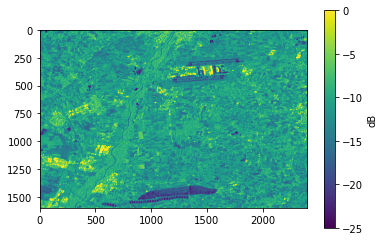

In [13]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    # Problem: border pixel might be zero or negative
    # pixel eqal or smaller than zero are set to nan
    array = np.copy(vv[x])
    array[array <= 0] = np.nan
    # plot backscatter data in dB scale
    plt.imshow(10*np.log10(array))
    cbar = plt.colorbar()
    cbar.set_label('dB')
    plt.clim(-25, 0)

interactive_plot = interactive(f, x=(0,len(vv)-1))
interactive_plot